# Background

- Since I am struggling to get an adequate model for rotating the probe, I want to check that the measured value is constant when repeating the measurement at each step.
- Appears that magnet shut off during one of the long runs, but I'm not sure when. First thing to check is if I can see what happened.

# Imports

In [63]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [64]:
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from pandas.api.types import is_numeric_dtype
from scipy.interpolate import interp1d
from scipy.spatial.transform import Rotation
import lmfit as lm
from copy import deepcopy
#from dateutil import parser
from plotly import graph_objects as go
from plotly.offline import plot
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
from plotting import config_plots, datetime_plt, get_label
from load_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d, scatter2d, histo, spherical_scatter3d
from mu2e.mu2eplots import mu2e_plot3d
# V vs. B, T (2021 results)
from V_vs_B_T import V_forward, inv_B_v2, invert_row, calc_B_column

# from pandas.api.types import is_numeric_dtype
# from dateutil import parser

config_plots()
# plt.rcParams.update({"text.usetex": True})

In [65]:
ddir = '/home/ckampa/Dropbox/LogFiles/temp_rotate_07-06-22/'

In [66]:
# 9-22-22 11:10, probe ##, rotating in magnet, fine scan, repeated (don't remember number of times...)
# PGC @ 20 deg C
# 1 deg steps -10 -- +6 angle 0 (theta)
# 2 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2022-09-22_11:10/'
scanfile = ddir+'2022-09-22 111055.txt'
slowfile = ddir+'2022-09-22 110650slow.txt'

# Load & Process Data

In [75]:
# temperature
df_temp = load_data(slowfile)

In [76]:
#df_temp = df_temp.query('"2022-09-29 00:00:00" <= Datetime <= "2022-09-29 03:00:00"')

In [77]:
df_temp

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1,Coil 2,LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke (near pole),...,Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),NaN (NWC-S),Supply PS (FNAL),NMR [T],NMR [FFT],seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-22 11:06:51,9/22/2022 11:06:51 AM,160.045423,18.519207,23.440748,22.452414,7.196333,9.823046,8.030878,10.662666,17.960081,...,10.353431,27.326878,7.319365,17.404776,37.681442,0.905853,0.0,0.0,0.000000,0.000000
2022-09-22 11:07:28,9/22/2022 11:07:28 AM,160.045140,18.516360,23.400450,22.430757,7.733467,10.220715,8.480744,11.027982,17.960337,...,10.582535,26.237888,7.680405,17.342024,37.667606,0.905852,0.0,37.0,0.010278,0.000428
2022-09-22 11:12:29,9/22/2022 11:12:29 AM,160.045140,18.517595,23.434988,22.444061,7.627031,10.152224,8.389920,10.951269,17.956804,...,10.509690,27.216948,7.548791,17.350109,37.657105,0.905853,0.0,338.0,0.093889,0.003912
2022-09-22 11:17:29,9/22/2022 11:17:29 AM,160.045083,18.520993,23.463825,22.483364,7.174873,9.815273,8.083300,10.682739,17.958061,...,10.240588,27.635592,7.131288,17.388174,37.662334,0.905852,0.0,638.0,0.177222,0.007384
2022-09-22 11:22:28,9/22/2022 11:22:28 AM,160.045140,18.523637,23.494982,22.517912,6.818679,9.592212,7.790638,10.473483,17.961613,...,10.137519,29.424843,6.653339,17.414095,37.631912,0.905853,0.0,937.0,0.260278,0.010845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11 14:12:32,10/11/2022 2:12:32 PM,-0.004425,-0.000007,9.407865,9.682930,7.329126,7.612905,8.924720,7.876338,14.771700,...,8.532351,25.290564,8.523191,16.492048,21.352547,0.000000,0.0,1652741.0,459.094722,19.128947
2022-10-11 14:17:32,10/11/2022 2:17:32 PM,-0.004499,-0.000007,9.432843,9.679563,7.071252,7.407420,8.778985,7.711514,14.764896,...,8.322093,26.391088,8.331898,16.522572,21.357773,0.000000,0.0,1653041.0,459.178056,19.132419
2022-10-11 14:22:32,10/11/2022 2:22:32 PM,-0.004465,-0.000007,9.415342,9.699903,6.577801,7.020548,8.493602,7.362854,14.769837,...,8.023325,26.613360,7.850647,16.509428,21.351898,0.000000,0.0,1653341.0,459.261389,19.135891


<AxesSubplot:xlabel='Datetime'>

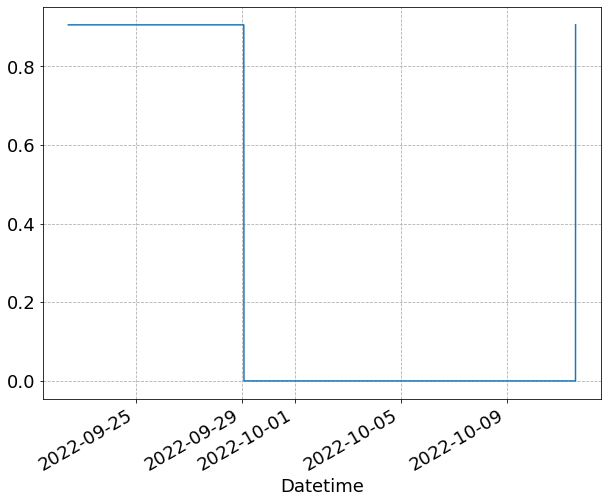

In [78]:
df_temp['NMR [T]'].plot()

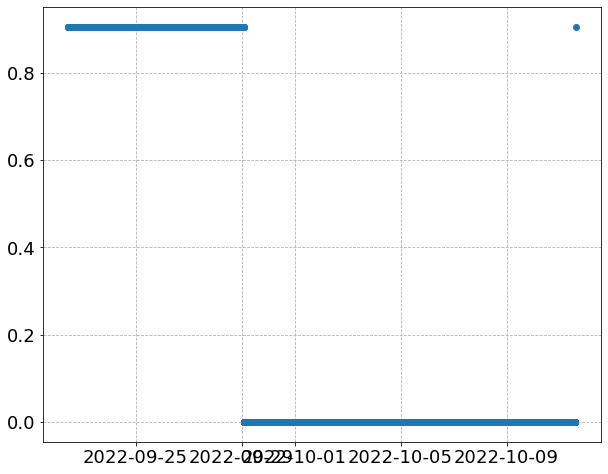

In [79]:
fig, ax = plt.subplots()

ax.scatter(df_temp.index, df_temp['NMR [T]'])

<AxesSubplot:xlabel='Datetime'>

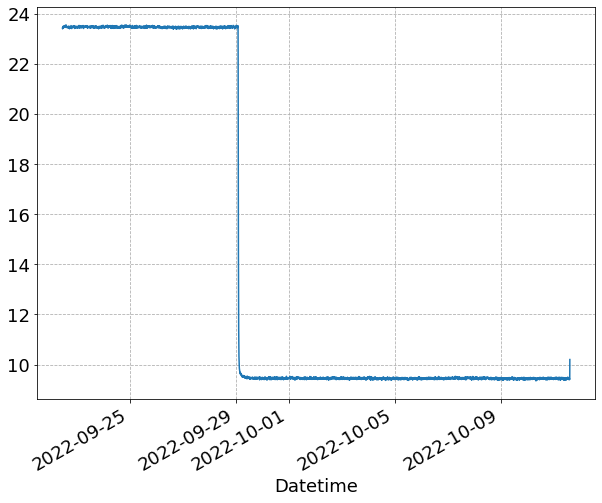

In [80]:
df_temp['Coil 1'].plot()

<AxesSubplot:xlabel='Datetime'>

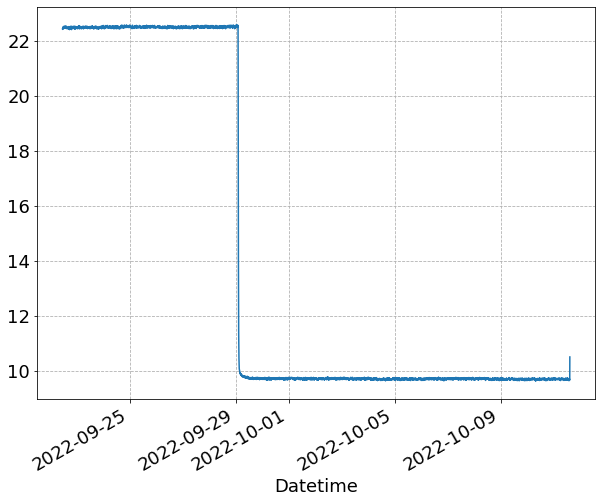

In [81]:
df_temp['Coil 2'].plot()

<AxesSubplot:xlabel='Datetime'>

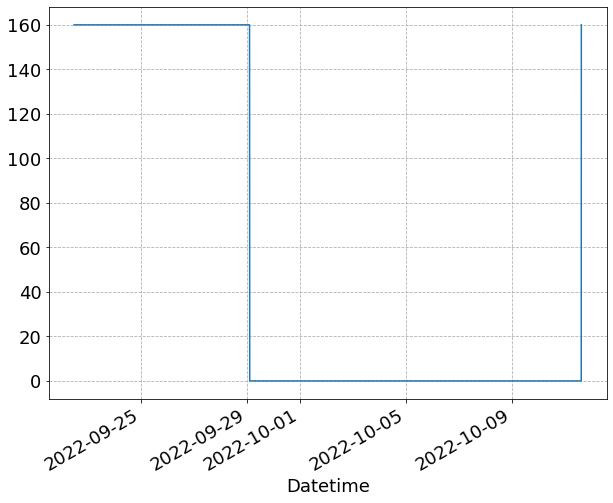

In [82]:
df_temp['Magnet Current [A]'].plot()

<AxesSubplot:xlabel='Datetime'>

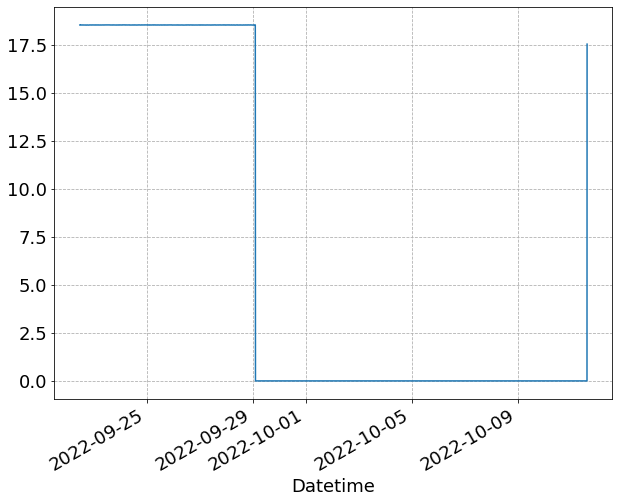

In [83]:
df_temp['Magnet Voltage [V]'].plot()

<AxesSubplot:xlabel='Datetime'>

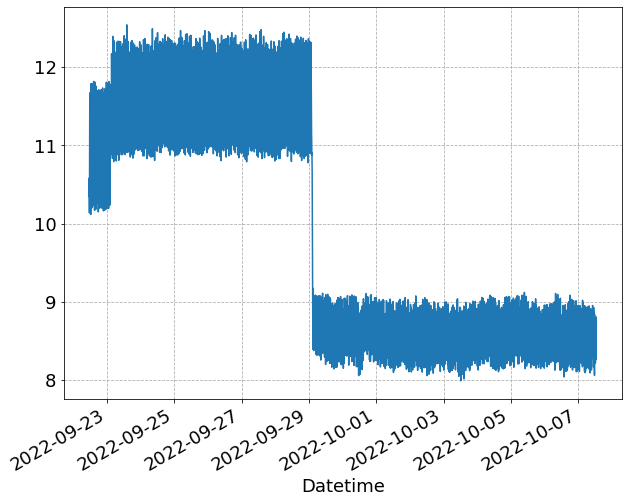

In [20]:
df_temp['Return Magnet (NWC-R)'].plot()

<AxesSubplot:xlabel='Datetime'>

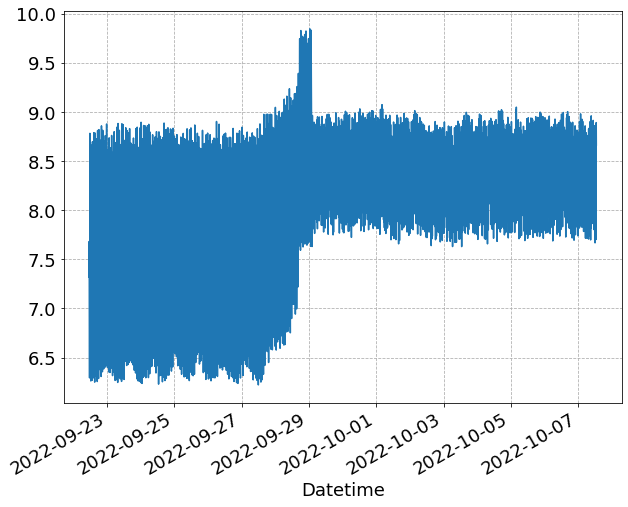

In [21]:
df_temp['Supply Magnet (NWC-S)'].plot()

In [8]:
len(df_temp)

4345

In [22]:
df_temp = df_temp.query('`NMR [T]` > 0.7').copy()

In [23]:
len(df_temp)

1909

<AxesSubplot:xlabel='Datetime'>

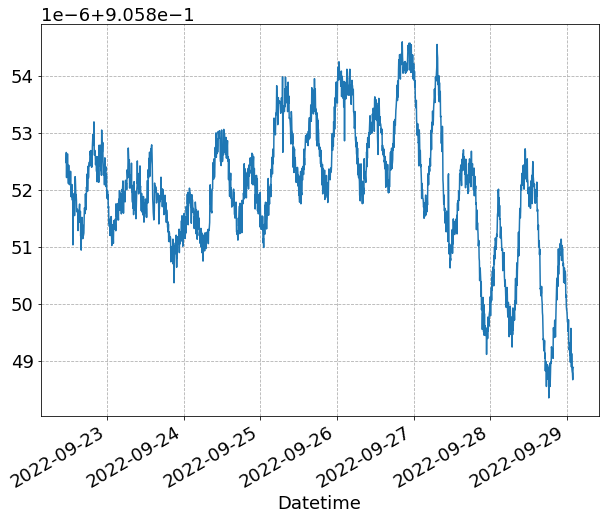

In [24]:
df_temp['NMR [T]'].plot()

In [25]:
df_temp['NMR [T]']

Datetime
2022-09-22 11:06:51    0.905853
2022-09-22 11:07:28    0.905852
2022-09-22 11:12:29    0.905853
2022-09-22 11:17:29    0.905852
2022-09-22 11:22:28    0.905853
                         ...   
2022-09-29 01:42:30    0.905849
2022-09-29 01:47:30    0.905849
2022-09-29 01:52:30    0.905849
2022-09-29 01:57:30    0.905849
2022-09-29 02:02:30    0.905849
Name: NMR [T], Length: 1909, dtype: float64

In [26]:
df = load_data(scanfile).iloc[1:]

In [27]:
df

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],2F0000000D5EC73A_Raw_X,2F0000000D5EC73A_Raw_Y,2F0000000D5EC73A_Raw_Z,2F0000000D5EC73A_Raw_T,2F0000000D5EC73A_Cal_X,...,2F0000000D5EC73A_Cal_T,SmarAct_Pattern_Angle_1,SmarAct_Pattern_Angle_2,SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2,seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-22 11:11:50,9/22/2022 11:11:50 AM,160.045083,18.518665,0.0,0.0,-81085.0,-347931.0,-2494314.0,19854.0,0.895406,...,19.854,-8.0,-180.0,350.144679,-1.0,179.999984,-1.0,54.0,0.015000,0.000625
2022-09-22 11:11:57,9/22/2022 11:11:57 AM,160.045083,18.518367,0.0,0.0,-81101.0,-347946.0,-2494180.0,19856.0,0.895360,...,19.856,-8.0,-180.0,350.144716,-1.0,180.000000,-1.0,61.0,0.016944,0.000706
2022-09-22 11:12:04,9/22/2022 11:12:04 AM,160.045140,18.518143,0.0,0.0,-81132.0,-347834.0,-2494161.0,19858.0,0.895353,...,19.858,-8.0,-180.0,350.144632,-1.0,179.999991,-1.0,68.0,0.018889,0.000787
2022-09-22 11:12:28,9/22/2022 11:12:28 AM,160.045197,18.517632,0.0,0.0,-81117.0,-347881.0,-2494185.0,19862.0,0.895363,...,19.862,-8.0,-180.0,350.144671,-1.0,179.999997,-1.0,92.0,0.025556,0.001065
2022-09-22 11:12:35,9/22/2022 11:12:35 AM,160.045140,18.517475,0.0,0.0,-81082.0,-347852.0,-2494207.0,19864.0,0.895371,...,19.864,-8.0,-180.0,350.144714,-1.0,180.000003,-1.0,99.0,0.027500,0.001146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29 07:52:36,9/29/2022 7:52:36 AM,-0.004363,-0.000005,0.0,0.0,1125.0,2167.0,-6405.0,18330.0,0.002051,...,18.330,8.0,180.0,5.999983,0.0,180.000004,0.0,592900.0,164.694444,6.862269
2022-09-29 07:52:44,9/29/2022 7:52:44 AM,-0.004375,-0.000005,0.0,0.0,1184.0,2081.0,-6342.0,18331.0,0.002029,...,18.331,8.0,180.0,6.000007,0.0,179.999997,0.0,592908.0,164.696667,6.862361
2022-09-29 07:52:52,9/29/2022 7:52:52 AM,-0.004401,-0.000005,0.0,0.0,1297.0,2063.0,-6515.0,18332.0,0.002092,...,18.332,8.0,180.0,5.999989,0.0,180.000006,0.0,592916.0,164.698889,6.862454


In [29]:
# FIXME! not nice to hard code this...
df = df.query('Datetime <= "2022-09-29 02:02:00"')

<AxesSubplot:xlabel='Datetime'>

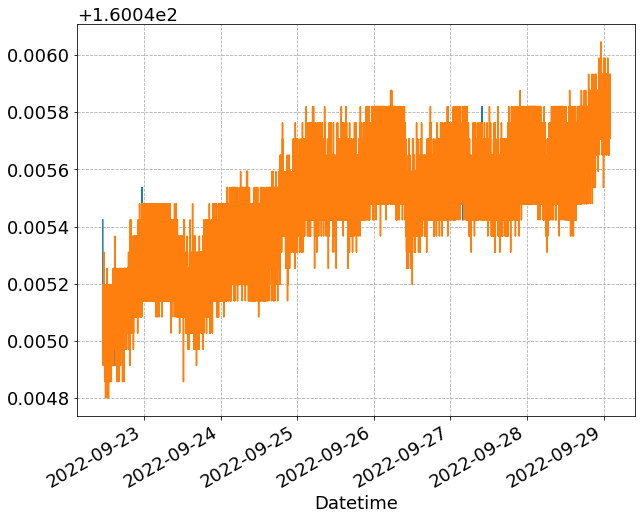

In [30]:
df_temp['Magnet Current [A]'].plot()
df['Magnet Current [A]'].plot()

In [31]:
df.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]',
       'NMR [FFT]', '2F0000000D5EC73A_Raw_X', '2F0000000D5EC73A_Raw_Y',
       '2F0000000D5EC73A_Raw_Z', '2F0000000D5EC73A_Raw_T',
       '2F0000000D5EC73A_Cal_X', '2F0000000D5EC73A_Cal_Y',
       '2F0000000D5EC73A_Cal_Z', '2F0000000D5EC73A_Cal_T',
       'SmarAct_Pattern_Angle_1', 'SmarAct_Pattern_Angle_2',
       'SmarAct_Meas_Angle_1', 'SmarAct_Meas_Rotation_Angle_1',
       'SmarAct_Meas_Angle_2', 'SmarAct_Meas_Rotation_Angle_2',
       'seconds_delta', 'hours_delta', 'days_delta'],
      dtype='object')

In [32]:
def get_probe_IDs(df):
    probes = [c[:-6] for c in df.columns if "Raw_X" in c]
    return sorted(probes)

In [33]:
probes = get_probe_IDs(df)
probe = probes[0]

In [34]:
probes, probe

(['2F0000000D5EC73A'], '2F0000000D5EC73A')

In [35]:
# Hall probe calculations
for p in probes:
    for t in ['Raw', 'Cal']:
        df[f'{p}_{t}_Bmag'] = (df[f'{p}_{t}_X']**2 + df[f'{p}_{t}_Y']**2 + df[f'{p}_{t}_Z']**2)**(1/2)
        df[f'{p}_{t}_Theta'] = np.arccos(df[f'{p}_{t}_Z']/df[f'{p}_{t}_Bmag'])
        df[f'{p}_{t}_Phi'] = np.arctan2(df[f'{p}_{t}_Y'],df[f'{p}_{t}_X'])
# again using theta redefining Cal components
for p in probes:
    for t in ['Cal']:
        df[f'{p}_{t}_Theta2'] = np.arccos(df[f'{p}_{t}_X']/df[f'{p}_{t}_Bmag'])
        df[f'{p}_{t}_Phi2'] = np.arctan2(df[f'{p}_{t}_Z'],df[f'{p}_{t}_Y'])

In [36]:
df['Magnet Resistance [Ohm]'] = df['Magnet Voltage [V]'] / df['Magnet Current [A]']
df['Coil Resistance [Ohm]'] = 2*df['Magnet Resistance [Ohm]']
df['Magnet Power [W]'] = df['Magnet Voltage [V]'] * df['Magnet Current [A]']

In [37]:
df[['Magnet Power [W]', 'Coil Resistance [Ohm]']]

,Magnet Power [W],Coil Resistance [Ohm]
Datetime,,
2022-09-22 11:11:50,2963.821283,0.231418
2022-09-22 11:11:57,2963.773536,0.231414
2022-09-22 11:12:04,2963.738842,0.231412
2022-09-22 11:12:28,2963.658002,0.231405
2022-09-22 11:12:35,2963.631879,0.231403
...,...,...
2022-09-29 02:01:29,2965.766145,0.231568
2022-09-29 02:01:36,2965.712513,0.231563
2022-09-29 02:01:44,2965.641843,0.231558


<AxesSubplot:xlabel='Datetime'>

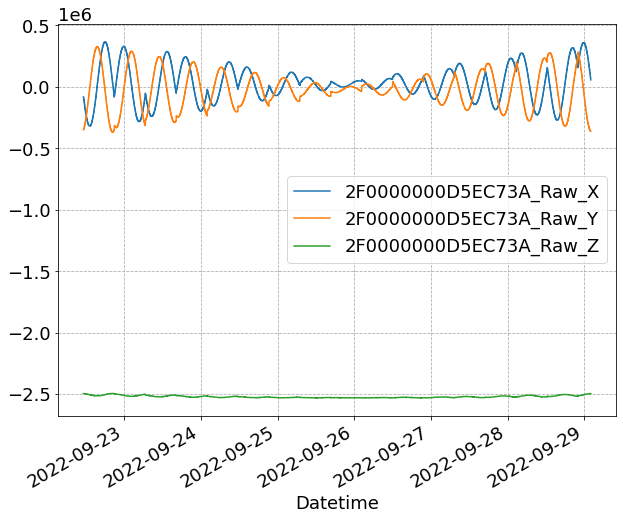

In [38]:
df[[f'{probe}_Raw_{i}' for i in ['X', 'Y', 'Z']]].plot()

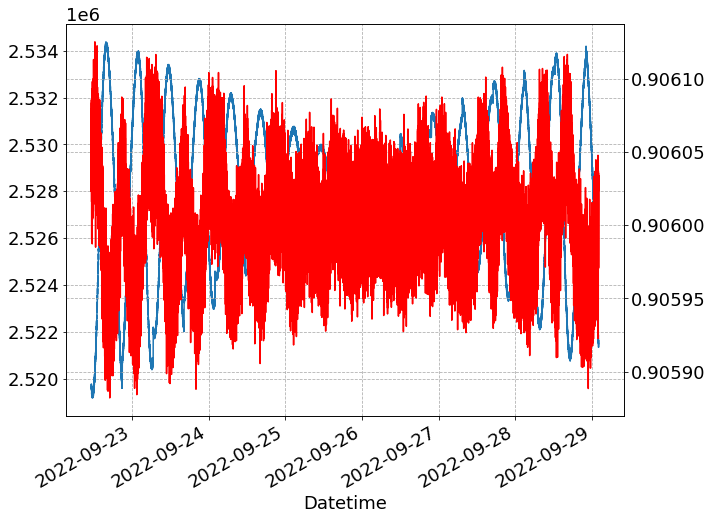

In [39]:
ax = df[f'{probe}_Raw_Bmag'].plot()
ax2 = ax.twinx()
ax2.plot(df.index, df[f'{probe}_Cal_Bmag'], 'r')

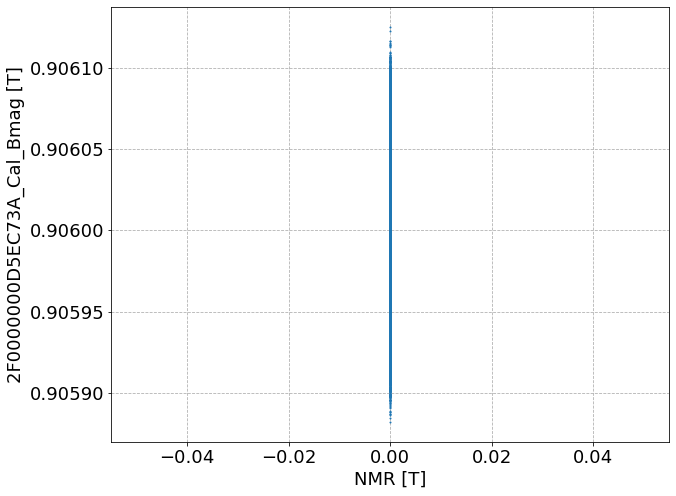

In [42]:
fig, ax = plt.subplots()

ax.scatter(df['NMR [T]'], df[f'{probe}_Cal_Bmag'], s=1)

ax.set_xlabel('NMR [T]')
ax.set_ylabel(f'{probe}_Cal_Bmag [T]');

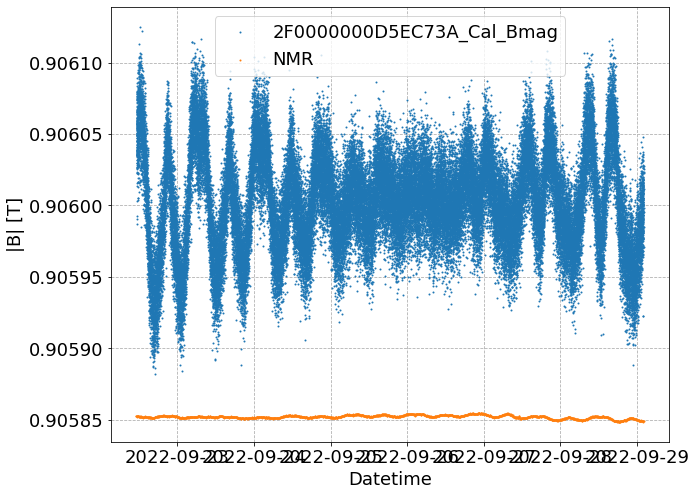

In [43]:
fig, ax = plt.subplots()

ax.scatter(df.index, df[f'{probe}_Cal_Bmag'], s=1, label=f'{probe}_Cal_Bmag')
ax.scatter(df_temp.index, df_temp[f'NMR [T]'], s=1, label='NMR')

ax.set_xlabel('Datetime')
ax.set_ylabel(f'|B| [T]')
ax.legend();

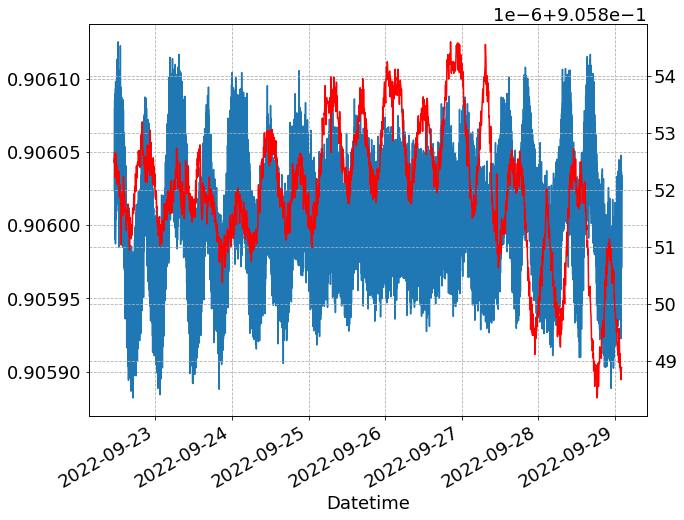

In [44]:
ax = df[f'{probe}_Cal_Bmag'].plot()
ax2 = ax.twinx()
ax2.plot(df_temp.index, df_temp['NMR [T]'], 'r')

- **STOPPED HERE: 10/07/22 13:21**

<AxesSubplot:xlabel='Datetime'>

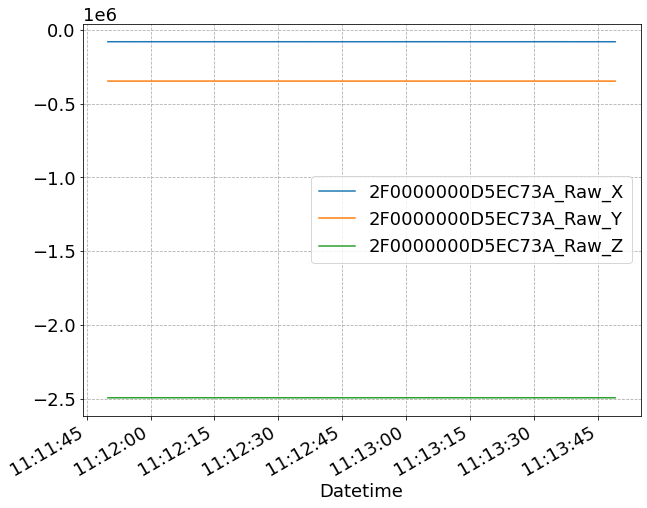

In [40]:
df[[f'{probe}_Raw_{i}' for i in ['X', 'Y', 'Z']]].iloc[:15].plot()

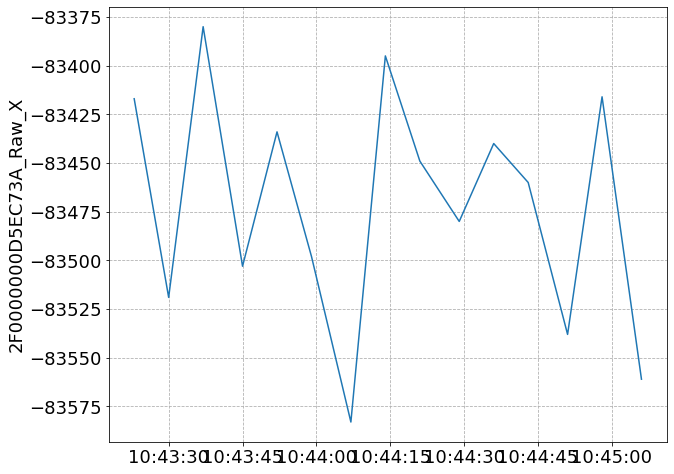

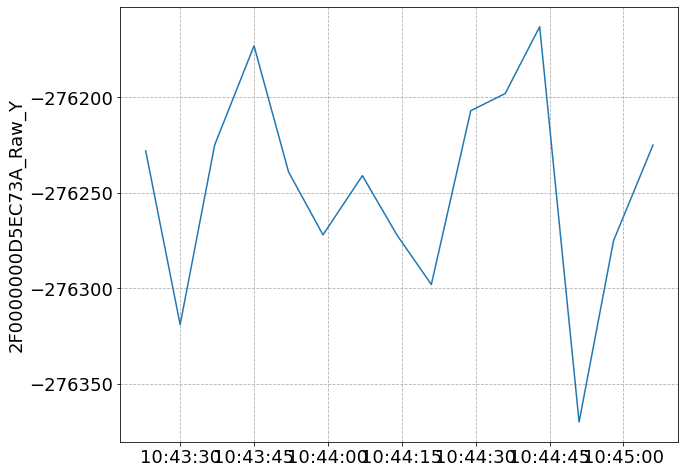

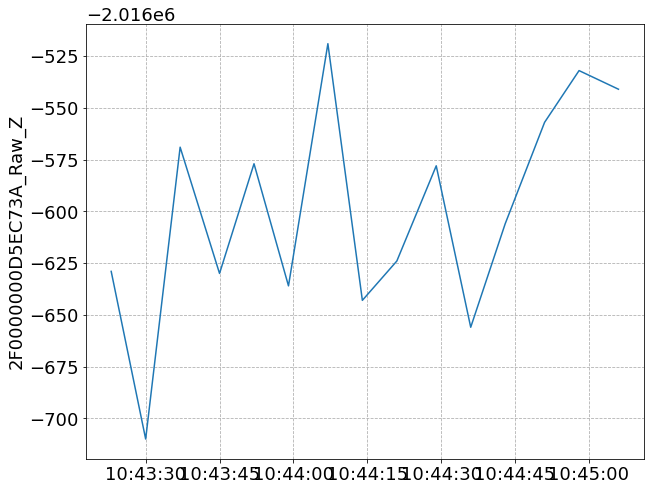

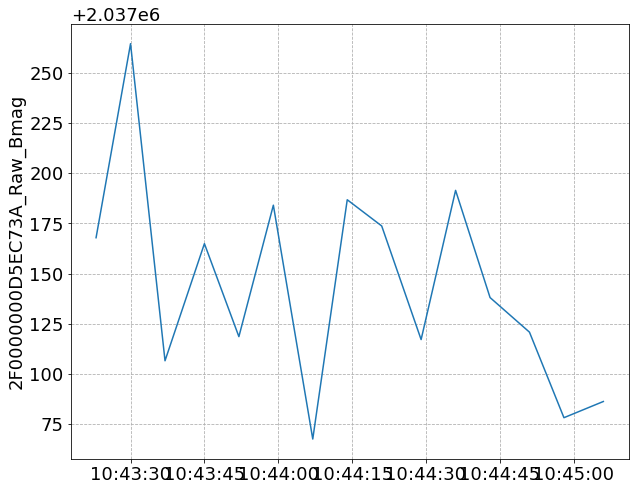

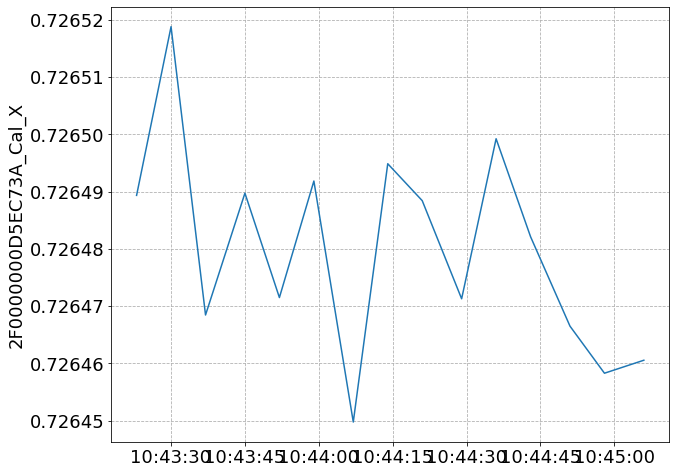

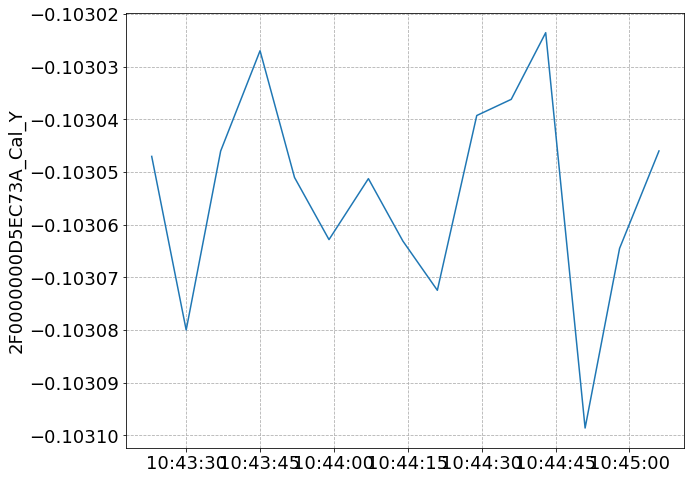

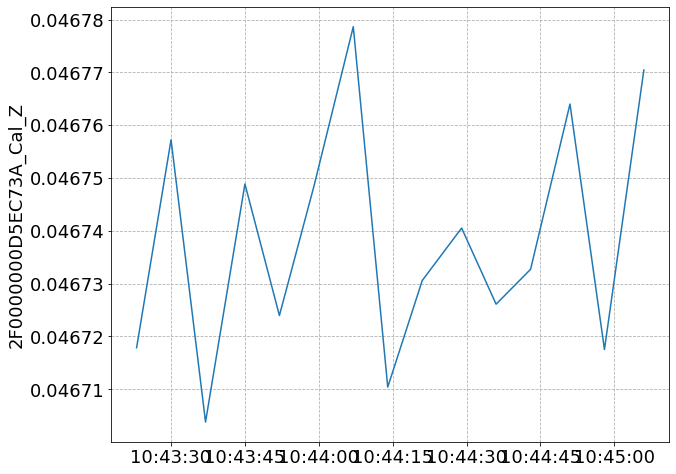

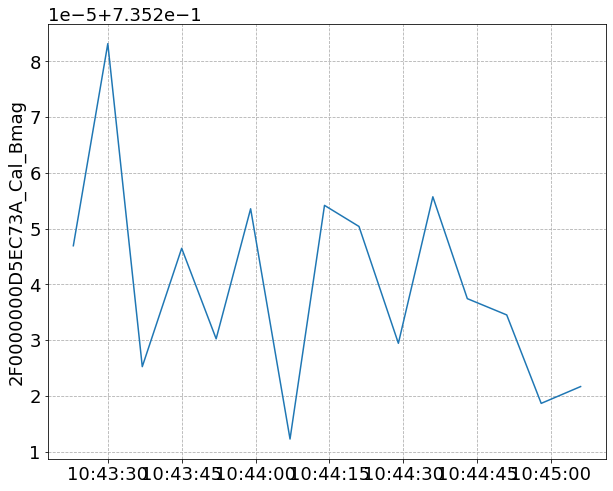

In [71]:
N = 2
for cal in ['Raw', 'Cal']:
    for i in ['X', 'Y', 'Z', 'Bmag']:
        fig, ax = plt.subplots()
        ax.plot(df.iloc[:15].index, df[f'{probe}_{cal}_{i}'].iloc[N*15:(N+1)*15])
        ax.set_ylabel(f'{probe}_{cal}_{i}')